<a href="https://colab.research.google.com/github/EmmaCOo/ADS509_Text_Mining_Final_Project/blob/main/Final_Project_Classification%26TopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**ADS509_TEXT_MINING_FINAL_PROJECT - DATA PREPROCESSING**

**EMMA OO**



The clearly defined problem statement and data description

Tokenization and normalization choices
**Descriptive statistics**
Overview of your classification model
Overview of your topic model
Estimates of performance for both models
Results
Discussion and conclusion





In [1]:
!pip install emoji==1.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 29.5 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=6e357a188a6b785f8091acfd0089218e79596361631a6ce0ddcd678d4a327256
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [2]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
import nltk
nltk.download('stopwords')
sw = stopwords.words("english")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
import html 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
#load all csv files
burger = pd.read_csv('/content/drive/MyDrive/TM_Final/BurgerKing_followers.txt', sep = '\t')
jackbox = pd.read_csv('/content/drive/MyDrive/TM_Final/JackBox_followers.txt', sep = '\t')
inn = pd.read_csv('/content/drive/MyDrive/TM_Final/innoutburger_followers.txt',sep = '\t')
chickfila = pd.read_csv('/content/drive/MyDrive/TM_Final/ChickfilA_followers.txt',sep = '\t')
sonic = pd.read_csv('/content/drive/MyDrive/TM_Final/sonicdrivein_followers.txt',sep = '\t')

In [4]:
#Drop all records with Na description
burger_df = burger[burger["description"].str.strip().str.len()>0]
jackbox_df = jackbox[jackbox["description"].str.strip().str.len()>0]
inn_df = inn[inn["description"].str.strip().str.len()>0]
chick_df = chickfila[chickfila["description"].str.strip().str.len()>0]
sonic_df = sonic[sonic["description"].str.strip().str.len()>0]

In [5]:
#print the shape of each dataset
burger_df.shape, jackbox_df.shape, inn_df.shape, chick_df.shape, sonic_df.shape

((57325, 8), (36006, 8), (57329, 8), (68737, 8), (59924, 8))

In [6]:
#Add the class columns to each dataframe
burger_df['chain'] = 'BurgerKing'
jackbox_df['chain'] = 'JackInTheBox'
inn_df['chain'] = 'Inn-N-Out'
chick_df['chain'] = 'Chick-Fil-A'
sonic_df['chain'] = 'Sonic'

#Merge all dataframes
frames = [burger_df, jackbox_df, inn_df, chick_df, sonic_df]
df = pd.concat(frames)
df.shape

(279321, 9)

In [7]:
df.head()

,ID,screen_name,name,location,follower_count,friends_count,like_count,description,chain
1,1475906563625865217,marcoShiva112,marcoShiva112,NaN,2,9,NaN,From Marcos (individual personality) to Shiva ...,BurgerKing
3,1361777286555525126,youngenaru,Enaru_,NaN,2,161,NaN,I am Polish youtuber. lol,BurgerKing
4,1485475728091414530,onyxx772,onyxx77,NaN,0,11,NaN,m,BurgerKing
5,1080764161603371008,Waqarali5075,SmarTboy 🇵🇰🇹🇷🛩,"کراچی, پاکستان",567,4447,NaN,✈‏Aviator ‏‏‏‏‏‏‏خواب تو اچھے دیکھو تم 🏅,BurgerKing
7,1571456733918134279,Sarah_John120,Sarah Johnston,"Birmingham, England",127,3166,NaN,26| So proud to be Scottish. World is wide. le...,BurgerKing


In [8]:
#substract only descriptin (text data) and classes
text_df = df[['description','chain']]
text_df.head()

,description,chain
1,From Marcos (individual personality) to Shiva ...,BurgerKing
3,I am Polish youtuber. lol,BurgerKing
4,m,BurgerKing
5,✈‏Aviator ‏‏‏‏‏‏‏خواب تو اچھے دیکھو تم 🏅,BurgerKing
7,26| So proud to be Scottish. World is wide. le...,BurgerKing


In [9]:
punctuation = set(punctuation) # speeds up comparison

def remove_punc(text):
  text_nonpunc ="".join([char for char in text if char not in punctuation])
  return text_nonpunc

# Define Tokenization Function
#To keep the emojis while tokenizing
RE_TOKEN = re.compile(r"""
                   ( [#]?[@\w'’\.\-\:]*\w     # words, hashtags and email addresses
                   | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
                   | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
                   )
                  """, re.VERBOSE)

def tokenize(text):
  return text.split()

# Define Stop Words Remove Function
stopwords = set(nltk.corpus.stopwords.words('english'))

def remove_stop(text):
  return [t for t in text if t not in stopwords]


# Define pipeline of lowering, no punctuation, tokenization, and removal of stopwords
pipeline = [str.lower, remove_punc,tokenize, remove_stop]
def prepare(text, pipeline): 
  tokens = text
  for transform in pipeline: tokens = transform(tokens)
  return tokens

In [10]:
# change the data frame to string data types
text_df = text_df.astype(str)

#replace Na values with '' 
text_df['description'] = text_df['description'].replace(np.nan, '')

In [11]:
text_df['tokens'] = text_df['description'].apply(prepare, pipeline = pipeline)
text_df.head()

,description,chain,tokens
1,From Marcos (individual personality) to Shiva ...,BurgerKing,"[marcos, individual, personality, shiva, sourc..."
3,I am Polish youtuber. lol,BurgerKing,"[polish, youtuber, lol]"
4,m,BurgerKing,[]
5,✈‏Aviator ‏‏‏‏‏‏‏خواب تو اچھے دیکھو تم 🏅,BurgerKing,"[✈‏aviator, ‏‏‏‏‏‏‏خواب, تو, اچھے, دیکھو, تم, 🏅]"
7,26| So proud to be Scottish. World is wide. le...,BurgerKing,"[26, proud, scottish, world, wide, let, make, ..."


In [12]:
text_df['length_before_cleaning'] = text_df['description'].apply(lambda x: len(x))  # length of raw texts
text_df['length_after_cleaning'] = text_df['tokens'].apply(lambda x: len(x))  # length of cleand words
text_df.head()

,description,chain,tokens,length_before_cleaning,length_after_cleaning
1,From Marcos (individual personality) to Shiva ...,BurgerKing,"[marcos, individual, personality, shiva, sourc...",159,14
3,I am Polish youtuber. lol,BurgerKing,"[polish, youtuber, lol]",25,3
4,m,BurgerKing,[],1,0
5,✈‏Aviator ‏‏‏‏‏‏‏خواب تو اچھے دیکھو تم 🏅,BurgerKing,"[✈‏aviator, ‏‏‏‏‏‏‏خواب, تو, اچھے, دیکھو, تم, 🏅]",40,7
7,26| So proud to be Scottish. World is wide. le...,BurgerKing,"[26, proud, scottish, world, wide, let, make, ...",70,8


In [13]:
#Distribution of each cain
df['chain'].value_counts()

Chick-Fil-A     68737
Sonic           59924
Inn-N-Out       57329
BurgerKing      57325
JackInTheBox    36006
Name: chain, dtype: int64

Text(0.5, 1.0, 'Distribution of Burger Chains')

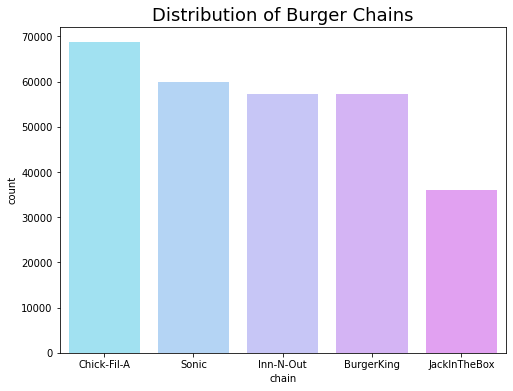

In [14]:
# Figur size
plt.figure(figsize=(8,6))

# countplot
sns.countplot( x = 'chain', data = text_df, palette = 'cool', alpha = 0.5, order = text_df['chain'].value_counts().index)

# Add title
plt.title('Distribution of Burger Chains', fontsize=18)

###**DESCRIPTIVE STATISTICS**


In [15]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    
    #filled na with whitespace to work with df and making sure it will
    #not be counted on frequent words
    tokens = [token for token in tokens if token not in ['', " "]]
    # Fill in the correct values here. 
    num_tokens =  len(tokens)
    num_unique_tokens = len(set(tokens)) #len(np.unique(tokens))
    lexical_diversity =  len(set(tokens)) / len(tokens) 
    num_characters =  sum([len(i) for i in tokens]) 
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(Counter(tokens).most_common(5))

        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [16]:
#BURGER KING
burger_king_df = text_df[text_df['chain'].str.contains('BurgerKing')]
token_burgerking = []
for i in burger_king_df['tokens']:
    token_burgerking.extend(i)    
print('Descriptive Stats of BURGER KING follower description text token:')
descriptive_stats(token_burgerking)

#JACK IN THE BOX
jackbox_df = text_df[text_df['chain'].str.contains('JackInTheBox')]
token_jack = []
for i in jackbox_df['tokens']:
    token_jack.extend(i)
print('\n')
print('Descriptive Stats of JACK-IN-THE-BOX follower description text token:')
descriptive_stats(token_jack)

#Inn-N-Out
innout_df = text_df[text_df['chain'].str.contains('Inn-N-Out')]
token_inn = []
for i in innout_df['tokens']:
    token_inn.extend(i)
print('\n')
print('Descriptive Stats of INN-N-OUT follower description text token:')
descriptive_stats(token_inn)

#CHICK-FIL-A
chickfila_df = text_df[text_df['chain'].str.contains('Chick-Fil-A')]
token_chick = []
for i in chickfila_df['tokens']:
    token_chick.extend(i)
print('\n')
print('Descriptive Stats of CHICK-FIL-A follower description text token:')
descriptive_stats(token_chick)

#SONIC DRIVE IN
sonicdrive_df = text_df[text_df['chain'].str.contains('Sonic')]
token_sonic = []
for i in sonicdrive_df['tokens']:
    token_sonic.extend(i)
print('\n')
print('Descriptive Stats of SONIC-DRIVEIN follower description text token:')
descriptive_stats(token_sonic)

Descriptive Stats of BURGER KING follower description text token:
There are 361512 tokens in the data.
There are 89563 unique tokens in the data.
There are 2091824 characters in the data.
The lexical diversity is 0.248 in the data.
[('love', 4000), ('im', 3787), ('like', 2170), ('life', 1965), ('fan', 1505)]


Descriptive Stats of JACK-IN-THE-BOX follower description text token:
There are 301140 tokens in the data.
There are 67050 unique tokens in the data.
There are 1847325 characters in the data.
The lexical diversity is 0.223 in the data.
[('love', 2306), ('life', 1840), ('fan', 1653), ('im', 1447), ('•', 1304)]


Descriptive Stats of INN-N-OUT follower description text token:
There are 361475 tokens in the data.
There are 89558 unique tokens in the data.
There are 2091679 characters in the data.
The lexical diversity is 0.248 in the data.
[('love', 4001), ('im', 3786), ('like', 2172), ('life', 1966), ('fan', 1505)]


Descriptive Stats of CHICK-FIL-A follower description text token:

[401075, 84136, 0.20977622639157265, 2350044]

In [17]:
text_df['tokens_str'] = text_df['tokens'].str.join(" ")
text_df.head()

,description,chain,tokens,length_before_cleaning,length_after_cleaning,tokens_str
1,From Marcos (individual personality) to Shiva ...,BurgerKing,"[marcos, individual, personality, shiva, sourc...",159,14,marcos individual personality shiva source cre...
3,I am Polish youtuber. lol,BurgerKing,"[polish, youtuber, lol]",25,3,polish youtuber lol
4,m,BurgerKing,[],1,0,
5,✈‏Aviator ‏‏‏‏‏‏‏خواب تو اچھے دیکھو تم 🏅,BurgerKing,"[✈‏aviator, ‏‏‏‏‏‏‏خواب, تو, اچھے, دیکھو, تم, 🏅]",40,7,✈‏aviator ‏‏‏‏‏‏‏خواب تو اچھے دیکھو تم 🏅
7,26| So proud to be Scottish. World is wide. le...,BurgerKing,"[26, proud, scottish, world, wide, let, make, ...",70,8,26 proud scottish world wide let make samememo...


In [18]:
text_df_test = text_df[['tokens_str','chain']]
text_df_list =  text_df_test.values.tolist()

In [19]:
word_cutoff = 0

tokens = [w for t, p in text_df_list for w in t.split()]
# tokens = [i for i in tokens if not i in sw] 

word_dist = nltk.FreqDist(tokens)

feature_words = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model.")

With a word cutoff of 0, we have 253402 as features in the model.


In [20]:
def conv_features(text,fw) :
    
    ret_dict = dict()
    token = text.lower().split()
    for word in token:
        if word in fw:
            ret_dict[word] = 1
        else:
            ret_dict[word] = 0
        
    return(ret_dict)

In [21]:
featuresets = [(conv_features(tokens_str,feature_words), chain) for (tokens_str, chain) in text_df_list]

test_size = 55000

In [22]:
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set)*100)

31.954545454545453


###**Since accuracy is not very optimal, let's do the TFIDF and CountVectorizer with several models to see if any improvement.**

###**TRAIN-TEST-SPLIT**

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(text_df['tokens'],text_df['chain'],test_size=0.2, random_state=42,
                                                    stratify=text_df['chain'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  223456
Size of Test Data  55865


##**TFIDF Vectorizer**


In [24]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)

tfidf = TfidfVectorizer(min_df = 1, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

X_test_tf = tfidf.transform(X_test)

####**BASELINE MODEL**

In [25]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, Y_train)

# make predictions using fitted model
dummy_train_pred = dummy_clf.predict(X_train)
dummy_test_pred = dummy_clf.predict(X_test)

target_names = ['Burger King', 'Jack In The Box', 'Inn-N-Out','Chick-Fil-A', 'Sonic Drivein']
dummy_cr = (classification_report(Y_test, dummy_test_pred))

print('Accuracy Score:', accuracy_score(Y_test, dummy_test_pred))
print('\n')
print(classification_report(Y_test, dummy_test_pred, target_names=target_names))

Accuracy Score: 0.2460932605387989


                 precision    recall  f1-score   support

    Burger King       0.00      0.00      0.00     11465
Jack In The Box       0.25      1.00      0.39     13748
      Inn-N-Out       0.00      0.00      0.00     11466
    Chick-Fil-A       0.00      0.00      0.00      7201
  Sonic Drivein       0.00      0.00      0.00     11985

       accuracy                           0.25     55865
      macro avg       0.05      0.20      0.08     55865
   weighted avg       0.06      0.25      0.10     55865



####**LINEAR SVC MODEL**

In [26]:
#Linear SVC Model

svc = LinearSVC(random_state=0, tol=1e-5)
svc = svc.fit(X_train_tf, Y_train)

svc_pred = svc.predict(X_test_tf)

print ('Accuracy Score - ', accuracy_score(Y_test, svc_pred))
print('\n')
print(classification_report(Y_test, svc_pred, target_names=target_names))

Accuracy Score -  0.22744115277902086


                 precision    recall  f1-score   support

    Burger King       0.04      0.04      0.04     11465
Jack In The Box       0.37      0.46      0.41     13748
      Inn-N-Out       0.04      0.04      0.04     11466
    Chick-Fil-A       0.35      0.26      0.30      7201
  Sonic Drivein       0.31      0.29      0.30     11985

       accuracy                           0.23     55865
      macro avg       0.22      0.22      0.22     55865
   weighted avg       0.22      0.23      0.22     55865



####**LOGISTIC REGRESSION**

In [27]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg = lg.fit(X_train_tf, Y_train)

lg_pred = lg.predict(X_test_tf)

print('Accuracy Score:', accuracy_score(Y_test, lg_pred))
print('\n')
print(classification_report(Y_test, lg_pred))

Accuracy Score: 0.2323816342969659


              precision    recall  f1-score   support

  BurgerKing       0.06      0.05      0.05     11465
 Chick-Fil-A       0.35      0.43      0.39     13748
   Inn-N-Out       0.10      0.12      0.11     11466
JackInTheBox       0.36      0.22      0.27      7201
       Sonic       0.31      0.29      0.30     11985

    accuracy                           0.23     55865
   macro avg       0.24      0.22      0.23     55865
weighted avg       0.23      0.23      0.23     55865



####**SGD**

#####**HYPERPARAMETER TUNING**

In [28]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import SGDClassifier

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
results = []

for a in alphas:
  pipe = make_pipeline(SGDClassifier(loss = 'log', penalty = 'l1', alpha = a, class_weight = 'balanced'))
  pipe.fit(X_train_tf, Y_train)


  train = pipe.predict(X_train_tf)
  test = pipe.predict(X_test_tf)

  train_acc = accuracy_score(Y_train, train)
  test_acc = accuracy_score(Y_test, test)
  
  results.append({'Alpha': a, 'Training Accuracy': train_acc, 'Test Accuracy':test_acc})

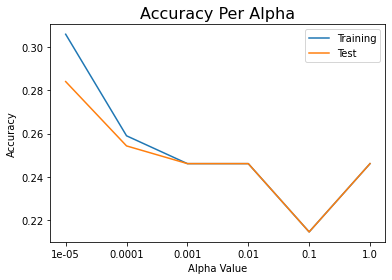

In [29]:
results_df = pd.DataFrame(results)

sns.lineplot(data = results_df['Training Accuracy'])
sns.lineplot(data = results_df['Test Accuracy'])

plt.title('Accuracy Per Alpha', size=16)
plt.legend(['Training','Test'])
plt.xlabel('Alpha Value')
plt.ylabel('Accuracy')
x_ticks = range(len(results_df['Alpha']))
plt.xticks(x_ticks, results_df['Alpha'])
plt.show()

Alpha values 0.00001 is the optimal according to the graph. 

In [30]:
lasso_model  = SGDClassifier(loss = 'log', penalty = 'l1', alpha = 0.00001, class_weight = 'balanced')
lasso = lasso_model.fit(X_train_tf, Y_train)

# predict the model
lasso_pred = lasso.predict(X_test_tf)

# Accuracy
lasso_accuracy = accuracy_score(Y_test, lasso_pred)
print('Accuracy Score:', lasso_accuracy)
print('\n')

#classification report
print(classification_report(Y_test, lasso_pred))

Accuracy Score: 0.2839165846236463


              precision    recall  f1-score   support

  BurgerKing       0.25      0.46      0.32     11465
 Chick-Fil-A       0.34      0.28      0.30     13748
   Inn-N-Out       0.24      0.11      0.15     11466
JackInTheBox       0.28      0.36      0.32      7201
       Sonic       0.33      0.24      0.28     11985

    accuracy                           0.28     55865
   macro avg       0.29      0.29      0.27     55865
weighted avg       0.29      0.28      0.27     55865



###**COUNT VECTORIZER**

Let's try Count Vectorizer to see if the accuracy improves. 

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
Xc_train = cv.fit_transform(X_train)  #train set

Xc_test = cv.transform(X_test)  #test set

####**LINEAR SVC MODEL**

In [32]:
#Linear SVC Model
svcc = LinearSVC(random_state=0, tol=1e-5)
svcc = svcc.fit(Xc_train, Y_train)

svcc_pred = svcc.predict(Xc_test)

print ('Accuracy Score - ', accuracy_score(Y_test, svcc_pred))
print('\n')
print(classification_report(Y_test, svcc_pred))

Accuracy Score -  0.25532981294191354


              precision    recall  f1-score   support

  BurgerKing       0.19      0.24      0.21     11465
 Chick-Fil-A       0.33      0.38      0.35     13748
   Inn-N-Out       0.14      0.11      0.12     11466
JackInTheBox       0.32      0.23      0.26      7201
       Sonic       0.29      0.29      0.29     11985

    accuracy                           0.26     55865
   macro avg       0.25      0.25      0.25     55865
weighted avg       0.25      0.26      0.25     55865



####**LOGISTIC REGRESSION**

In [33]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
c_lg = lg.fit(Xc_train, Y_train)

c_lg_pred = c_lg.predict(Xc_test)

print('Accuracy Score:', accuracy_score(Y_test, c_lg_pred))
print('\n')
print(classification_report(Y_test, c_lg_pred))

Accuracy Score: 0.26003759062024523


              precision    recall  f1-score   support

  BurgerKing       0.15      0.11      0.13     11465
 Chick-Fil-A       0.33      0.37      0.35     13748
   Inn-N-Out       0.20      0.27      0.23     11466
JackInTheBox       0.35      0.20      0.26      7201
       Sonic       0.30      0.29      0.30     11985

    accuracy                           0.26     55865
   macro avg       0.27      0.25      0.25     55865
weighted avg       0.26      0.26      0.26     55865



####**LASSO**

In [34]:
lasso = lasso_model.fit(Xc_train, Y_train)

# predict the model
c_lasso_pred = lasso.predict(Xc_test)

# Accuracy
c_lasso_accuracy = accuracy_score(Y_test, c_lasso_pred)

print('Accuracy Score:', c_lasso_accuracy)
print('\n')
print(classification_report(Y_test, c_lasso_pred))

Accuracy Score: 0.27473373310659627


              precision    recall  f1-score   support

  BurgerKing       0.23      0.36      0.28     11465
 Chick-Fil-A       0.35      0.29      0.31     13748
   Inn-N-Out       0.21      0.16      0.18     11466
JackInTheBox       0.29      0.32      0.31      7201
       Sonic       0.31      0.26      0.29     11985

    accuracy                           0.27     55865
   macro avg       0.28      0.28      0.27     55865
weighted avg       0.28      0.27      0.27     55865



###**PERFORMANCE METRICS FOR CLASSIFICATION MODELS**

In [35]:
labels = [1,2,3,4,5,6,7]

models = [dummy_test_pred, svc_pred, lasso_pred, lg_pred, svcc_pred, c_lg_pred, c_lasso_pred]
accuracy = []

for i in models: 
  accuracy_scores = accuracy_score(i, Y_test)
  accuracy.append(accuracy_scores)

In [65]:
# merge accuracy and f1_scores dataframe
accuracy = pd.DataFrame(accuracy, columns = ['Accuracy_score'])
accuracy_table = ((accuracy)*100).round(decimals = 2)
accuracy_table


accuracy_table.insert(0, 'Models', ['BaseLine','SVC-TFIDF','Lasso-TFIDF', 'Logistic-Regression-TFIDF','SVC-CountV','Logistic-Regression-CountV',
                                    'Lasso-CountV'])

accuracy_table.loc[7] = ['Naives-Bayes','31.96']
accuracy_table

,Models,Accuracy_score
0,BaseLine,24.61
1,SVC-TFIDF,22.74
2,Lasso-TFIDF,28.39
3,Logistic-Regression-TFIDF,23.24
4,SVC-CountV,25.53
5,Logistic-Regression-CountV,26.0
6,Lasso-CountV,27.47
7,Naives-Bayes,31.96


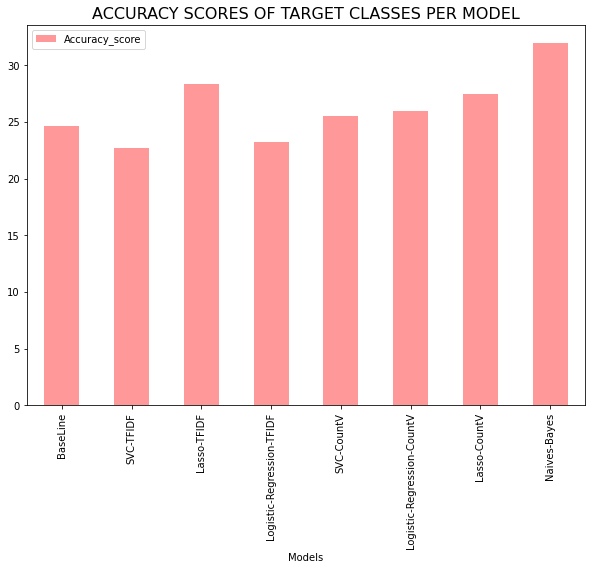

In [79]:
#Bargraph for Comparison of Accuracy for Each Model

accuracy_table['Accuracy_score']=accuracy_table['Accuracy_score'].astype(float)
accuracy_table.plot(x="Models", y= ['Accuracy_score'], kind = 'bar',figsize = (10,7), colormap = 'rainbow_r', alpha = 0.4)
plt.title('ACCURACY SCORES OF TARGET CLASSES PER MODEL', size = 16)
plt.show()

###**WORDCLOUD FOR EACH BURGER CHAIN**

#####**Group comparison to find out why the accuracy of each model are not optimal.**

In [36]:
# Define function to create wordcloud:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

        
   # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

Text(0.5, 1.0, 'Sonic DriveThrough WordCloud')

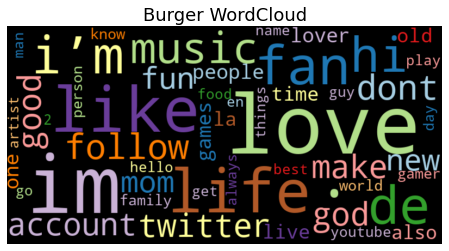

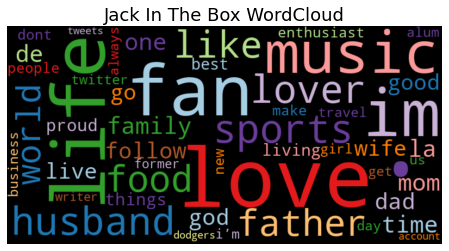

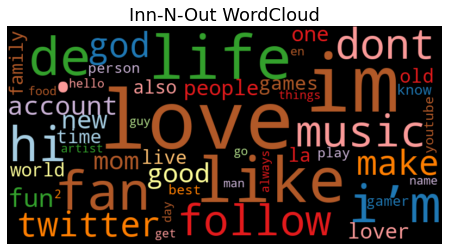

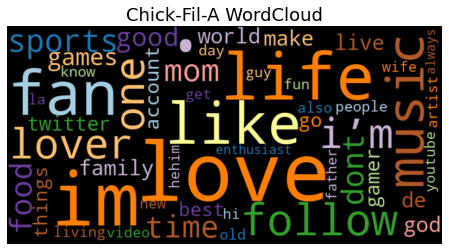

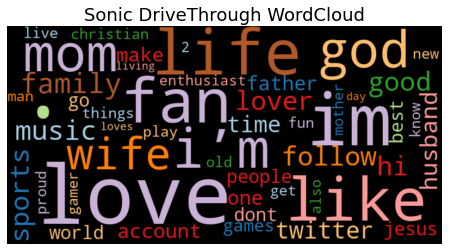

In [37]:
from wordcloud import WordCloud 

plt.figure(figsize=(8,4))
burger_wd= count_words(text_df[text_df['chain']=='BurgerKing'])
wordcloud(burger_wd['freq'], max_words= 50)
plt.title('Burger WordCloud', size = 18)

plt.figure(figsize=(8,4))
jbx_wd= count_words(text_df[text_df['chain']=='JackInTheBox'])
wordcloud(jbx_wd['freq'], max_words= 50)
plt.title('Jack In The Box WordCloud', size = 18)

plt.figure(figsize=(8,4))
inn_wd= count_words(text_df[text_df['chain']=='Inn-N-Out'])
wordcloud(inn_wd['freq'], max_words= 50)
plt.title('Inn-N-Out WordCloud', size = 18)

plt.figure(figsize=(8,4))
chick_wd= count_words(text_df[text_df['chain']=='Chick-Fil-A'])
wordcloud(chick_wd['freq'], max_words= 50)
plt.title('Chick-Fil-A WordCloud', size = 18)

plt.figure(figsize=(8,4))
sonic_wd= count_words(text_df[text_df['chain']=='Sonic'])
wordcloud(sonic_wd['freq'], max_words= 50)
plt.title('Sonic DriveThrough WordCloud', size = 18)


####**As we have seen from the Descriptive Statistics and WordCloud, all the burger chains share words such as 'love', 'like', 'life', 'fan', 'im' in very similar ways, the models seem to have difficult time classifiyig them resulting in the poor accuracies.**

###**TOPIC MODELING**

In [89]:
#!pip install pyLDAvis

In [81]:
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


####**LDA MODEL**

In [82]:
 #Countvectorizer without word counts less than 5 and more than 70%
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7) 
count_text_vectors = count_text_vectorizer.fit_transform(text_df["description"])
count_text_vectors.shape

(279321, 25139)

In [83]:
#TF-IDF (same parameters as CountVectorizer)
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(text_df['description'])
tfidf_text_vectors.shape

(279321, 25139)

####**NMF MODEL**

In [85]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [101]:
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
nmf_text_model = NMF(n_components=5, random_state=314)  #n_components =5 for five_topic to be detected by NMF
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [104]:
#summary of the topics that NMF detected in the text 
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  co (18.13)
  https (17.95)
  youtube (1.16)
  twitch (0.98)
  follow (0.62)

Topic 01
  hi (64.40)
  name (1.03)
  im (0.80)
  guys (0.53)
  twitter (0.47)

Topic 02
  love (16.93)
  family (1.75)
  god (1.43)
  music (1.07)
  laugh (0.80)

Topic 03
  life (10.53)
  living (2.32)
  live (2.07)
  best (1.12)
  mom (0.96)

Topic 04
  like (5.24)
  games (1.21)
  fun (1.16)
  follow (0.90)
  fan (0.88)


####**LSA MODEL**

In [105]:
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

#display 5 topic models
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  co (10.87)
  https (10.75)
  hi (2.14)
  love (1.32)
  youtube (0.79)

Topic 01
  hi (45.82)
  love (3.06)
  like (1.20)
  name (0.83)
  life (0.76)

Topic 02
  love (7.83)
  life (2.29)
  family (1.01)
  god (0.91)
  live (0.89)

Topic 03
  life (6.28)
  like (2.00)
  living (1.50)
  live (1.11)
  best (0.76)

Topic 04
  like (7.26)
  games (1.62)
  fun (1.21)
  fan (1.15)
  follow (1.06)


In [86]:
from sklearn.decomposition import LatentDirichletAllocation

lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_para_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_text_model.components_

display_topics(lda_text_model, count_text_vectorizer.get_feature_names())


Topic 00
  de (2.10)
  account (1.54)
  follow (1.26)
  la (1.24)
  twitter (1.16)

Topic 01
  life (2.53)
  love (2.27)
  god (1.37)
  hi (1.14)
  people (0.96)

Topic 02
  fan (2.73)
  like (1.05)
  sports (0.88)
  old (0.72)
  com (0.61)

Topic 03
  enthusiast (0.64)
  artist (0.64)
  social (0.57)
  lover (0.56)
  writer (0.56)

Topic 04
  co (3.32)
  love (3.21)
  https (2.92)
  mom (1.66)
  music (1.33)


In [87]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [88]:
pyLDAvis.display(lda_display)

#**NEED TO ADD DISTRIBUTION OF EACH TOPIC MODELS**